In [1]:
# default_exp datasets.generators

In [2]:
# hide
%load_ext autoreload
%autoreload 2

In [3]:
# hide
from nbdev import *

# Generators for MOT data

MOT data format can be [found here](https://github.com/JonathonLuiten/TrackEval/blob/master/docs/MOTChallenge-Official/Readme.md#data-format).

In [4]:
#exporti

from PIL import Image
from functools import partial
from pydantic import BaseModel
from typing import List, Optional, Tuple, Any, Iterator

In [5]:
from pandas import DataFrame
import numpy as np
from pathlib import Path
from skimage.draw import rectangle

In [6]:
#exporti
from skimage.draw import disk

In [7]:
#hide
import matplotlib.pyplot as plt

In [8]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
tmp_dir.name

'/tmp/tmp_jufii_8'

In [9]:
def show_img(img):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))
    ax.imshow(img)

## Create mot gt and render corresponding frames

In [10]:
#exporti
class TrackObject(BaseModel):
    id: int
    center: Tuple[int, int]
    color: Tuple[float, float, float]


class TrackObjectRectangle(TrackObject):
    size: Tuple[int, int]
    type: str = 'rectangle'


class TrackObjectCircle(TrackObject):
    radius: int
    type: str = 'circle'


class Frame(BaseModel):
    res: Tuple[int, int]
    pos: int
    objects: Optional[List[TrackObject]] = []
    img: Optional[Any]

In [11]:
#exporti
def gen_frame(n_frames=5, res=(200, 200)) -> Iterator[Frame]:
    for f in range(n_frames):
        yield Frame(pos=f, res=res)

In [12]:
#hide
list(gen_frame(n_frames=2))

[Frame(res=(200, 200), pos=0, objects=[], img=None),
 Frame(res=(200, 200), pos=1, objects=[], img=None)]

In [13]:
#exporti
def gen_bg_img(stream, bg='rand', channel=3) -> Iterator[Frame]:
    for gt in stream:
        # print(g)
        width, height = gt.res
        if bg == 'rand':
            img = np.random.rand(width, height, channel)
        else:
            img = np.zeros((width, height, channel), dtype=np.double)
        gt.img = img
        yield gt

In [14]:
#hide

frames = gen_frame()
bgs = list(gen_bg_img(frames))[0]
bgs.img.shape  # type: ignore

(200, 200, 3)

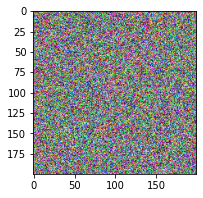

In [15]:
#hide
show_img(bgs.img)  # type: ignore

In [16]:
#exporti
def default_path(current_frame, start=(10, 10), speed=(5, 5), radius=10, type='rectangle'):
    initial_x, initial_y = start
    x_speed, y_speed = speed

    x = initial_x + current_frame * x_speed
    y = initial_y + current_frame * y_speed

    if type == 'circle':
        y = y + radius
        x = x + radius

    return (x, y)

In [17]:
#exporti
def gen_moving_object(stream, object_id, size=(20, 20), path_f=default_path,
                      type='rectangle', color=(1.0, 1.0, 1.0)) -> Iterator[Frame]:

    frame_nr = 0
    for gt in stream:
        if type == 'circle':
            center = path_f(frame_nr, type=type)
            radius = (min(size)) / 2
            o_track = TrackObjectCircle(id=object_id, center=center,
                                        radius=radius, color=color)
        else:
            center = path_f(frame_nr)
            # error: Incompatible types in assignment (expression has type
            # "TrackObjectRectangle", variable has type "TrackObjectCircle")
            o_track = TrackObjectRectangle(id=object_id, center=center,  # type: ignore
                                           size=size, color=color)

        gt.objects.append(o_track)
        frame_nr = frame_nr + 1
        yield gt

In [18]:
#hide
frames = gen_frame()
track1 = gen_moving_object(frames, object_id=0)
track2 = gen_moving_object(track1, object_id=1)
next(track2)

Frame(res=(200, 200), pos=0, objects=[TrackObjectRectangle(id=0, center=(10, 10), color=(1.0, 1.0, 1.0), size=(20, 20), type='rectangle'), TrackObjectRectangle(id=1, center=(10, 10), color=(1.0, 1.0, 1.0), size=(20, 20), type='rectangle')], img=None)

In [19]:
#exporti
def gen_render_objects(stream):
    for gt in stream:
        for o in gt.objects:
            if o.type == 'circle':
                rr, cc = disk(o.center, o.radius)
            else:
                rr, cc = rectangle(start=o.center, extent=o.size, shape=gt.img.shape)

            r, g, b = o.color
            gt.img[rr.astype(int), cc.astype(int), :] = [r, g, b]
        yield gt

In [20]:
#hide
def example_path_generator(current_frame, start=(50, 50), speed=(10, 5),
                           radius=10, type='rectangle', boost=2):
    initial_x, initial_y = start
    x_speed, y_speed = speed
    print()

    x = initial_x + current_frame * x_speed * boost
    y = initial_y + current_frame * y_speed

    if type == 'circle':
        y = y + radius

    return (x, y)

In [21]:
#hide
frames = gen_frame(n_frames=20)
track1 = gen_moving_object(frames, object_id=0, size=(20, 40),
                           path_f=partial(example_path_generator, boost=2))
track2 = gen_moving_object(track1, object_id=1, size=(40, 60), type='circle',
                           color=(1, 0, 0))
bg_img = gen_bg_img(track2, bg='')
track_img = gen_render_objects(bg_img)

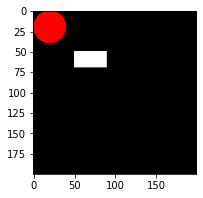

In [22]:
#hide
gt = next(track_img)
# print(gt)
show_img(gt.img)

In [23]:
#exporti

def occlude_lower_left_img(track_img, color=[0, 0, 0]):
    for gt in track_img:
        pos = (gt.res[0] / 2, gt.res[1] / 4)
        extent = (gt.res[0] / 3, gt.res[1] / 3)
        rr, cc = rectangle(start=pos, extent=extent, shape=gt.img.shape)
        gt.img[rr.astype(int), cc.astype(int), :] = color
        yield gt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


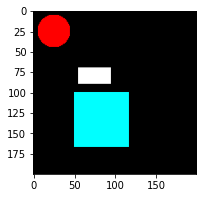

In [24]:
#hide
occluded_img = occlude_lower_left_img(track_img, color=[0, 32, 255])
oc = next(occluded_img)
show_img(oc.img)

In [25]:
#exporti
def gt_to_mot(gt: Frame):
    """mot format <frame>, <id>, <bb_left>,
        <bb_top>, <bb_width>, <bb_height>, <conf>, <label>, <vis>
    """
    # gt possible None
    for o in gt.objects:  # type: ignore
        cx = o.center[0]
        cy = o.center[1]
        mot = {
            'frame': gt.pos,
            'id': o.id,
            'conf': -1,
            'label': -1,
            'vis': -1
        }
        if o.type == 'circle':  # type: ignore
            mot['bb_left'] = cx - o.radius  # type: ignore
            mot['bb_top'] = cy - o.radius  # type: ignore
            mot['bb_width'] = o.radius * 2  # type: ignore
            mot['bb_height'] = o.radius * 2  # type: ignore
        else:
            mot['bb_left'] = cy
            mot['bb_top'] = cx
            mot['bb_width'] = o.size[1]  # type: ignore
            mot['bb_height'] = o.size[0]  # type: ignore

        yield mot

In [26]:
#export
def create_mot_ds(path: Path, img_path: str = 'img', n_frames: int = 20, occluded: bool = False):
    # create data
    frames = gen_frame(n_frames=n_frames)
    track1 = gen_moving_object(frames, object_id=0, size=(10, 30),
                               path_f=partial(default_path, start=(150, 10), speed=(0, 10)))
    track2 = gen_moving_object(track1, object_id=1, type='circle', color=(1, 0, 0), size=(40, 40),
                               path_f=partial(default_path, start=(40, 40), speed=(5, 5)))
    bg_img = gen_bg_img(track2)
    track_img = gen_render_objects(bg_img)

    if occluded:
        track_img = occlude_lower_left_img(track_img)

    # save to files
    _img_path = Path(path) / img_path
    _img_path.mkdir(parents=True, exist_ok=True)
    records = []

    for gt in track_img:
        frame_pos = str(gt.pos).zfill(4)
        file_path = _img_path / f"{frame_pos}.jpg"
        im = Image.fromarray((gt.img * 175.5).astype(np.uint8))  # Trasnform img to RGB

        im.save(file_path)

        for mot in gt_to_mot(gt):
            records.append(mot)

    df_gt = DataFrame.from_records(records)
    df_gt.to_csv(Path(path) / 'mot.csv', index=False)

In [27]:
#hide
create_mot_ds(Path(tmp_dir.name), occluded=True)

In [28]:
#hide
import os
os.listdir(f'{tmp_dir.name}/img')

['0013.jpg',
 '0002.jpg',
 '0009.jpg',
 '0010.jpg',
 '0012.jpg',
 '0019.jpg',
 '0008.jpg',
 '0005.jpg',
 '0001.jpg',
 '0000.jpg',
 '0004.jpg',
 '0017.jpg',
 '0006.jpg',
 '0011.jpg',
 '0015.jpg',
 '0014.jpg',
 '0018.jpg',
 '0003.jpg',
 '0016.jpg',
 '0007.jpg']

In [29]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_base.ipynb.
Converted 00a_annotator.ipynb.
Converted 00b_mltypes.ipynb.
Converted 00c_annotation_types.ipynb.
Converted 00d_doc_utils.ipynb.
Converted 01_bbox_canvas.ipynb.
Converted 01_helpers.ipynb.
Converted 01a_datasets.ipynb.


Converted 01a_datasets_download.ipynb.
Converted 01a_datasets_factory.ipynb.
Converted 01b_dataset_video.ipynb.
Converted 01b_tutorial_image_classification.ipynb.
Converted 01c_tutorial_bbox.ipynb.
Converted 01d_tutorial_video_annotator.ipynb.
Converted 02_navi_widget.ipynb.
Converted 02a_right_menu_widget.ipynb.
Converted 02b_grid_menu.ipynb.


Converted 03_storage.ipynb.
Converted 04_bbox_annotator.ipynb.
Converted 05_image_button.ipynb.
Converted 06_capture_annotator.ipynb.
Converted 07_im2im_annotator.ipynb.
Converted 08_tutorial_road_damage.ipynb.
Converted 09_voila_example.ipynb.
Converted 11_build_annotator_tutorial.ipynb.


Converted 12_debug_utils.ipynb.
Converted 13_datasets_legacy.ipynb.
Converted 14_datasets_factory_legacy.ipynb.
Converted 15_coordinates_input.ipynb.
Converted 16_custom_buttons.ipynb.
Converted 17_annotator_explorer.ipynb.
Converted 18_bbox_trajectory.ipynb.
Converted 19_bbox_video_annotator.ipynb.
Converted 20_image_classification_user_story.ipynb.
Converted index.ipynb.
